<bound method DataFrame.info of             weather_code  temperature_2m_max  temperature_2m_min  \
date                                                               
1940-01-01             1           -7.330999          -17.230999   
1940-01-02             3           -1.681000          -17.781000   
1940-01-03             3            1.219000           -6.631000   
1940-01-04             3            1.219000           -5.681000   
1940-01-05             1            2.069000           -7.431000   
...                  ...                 ...                 ...   
2024-12-26             2          -11.519501          -16.619500   
2024-12-27             3          -10.569500          -19.419500   
2024-12-28             3          -12.019501          -19.969500   
2024-12-29            71           -9.869500          -17.519500   
2024-12-30            71           -9.469501          -15.919500   

            temperature_2m_mean  apparent_temperature_max  \
date                  

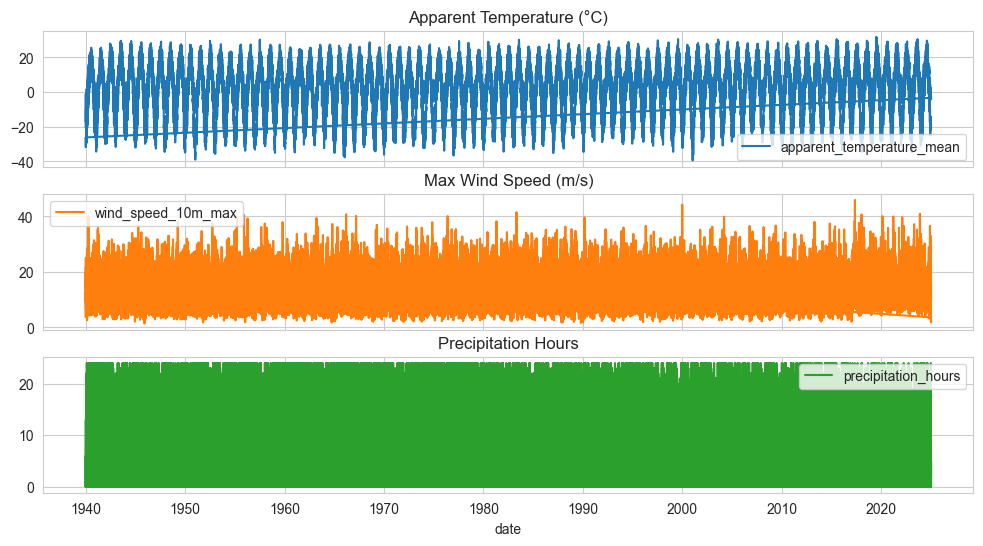

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


TypeError: agg function failed [how->mean,dtype->object]

In [3]:
from platform import win32_edition

from scipy.stats import gamma
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import month

from PreliminaryAnalysis import weather_monthly

# Load the CSV file
Weather = pd.read_csv("Data/clean.csv")

# Convert the date column to datetime and set it as the index
Weather["date"] = pd.to_datetime(Weather["date"])  # Keep as full datetime
Weather = Weather.set_index("date")

# Display information and statistical summary
pd.set_option('display.max_columns', None)


In [5]:
Weather.info()
print("Overview:")
Weather.head()

NameError: name 'Weather' is not defined

## Temperature Analysis

In [202]:
# Group by City, Year, and Month
monthly_aggregation = Weather.groupby(['City', Weather.index.year, Weather.index.month]).agg(
    monthly_mean_temp=('temperature_2m_mean', 'mean'),
    monthly_max_temp=('temperature_2m_max', 'mean'),
    monthly_min_temp=('temperature_2m_min', 'mean'),
    monthly_temp_sd=('temperature_2m_mean', 'std'),
    monthly_abs_max_temp=('temperature_2m_max', 'max'),
    monthly_abs_min_temp=('temperature_2m_min', 'min')
)
# Reset the index
monthly_aggregation.index.set_names(['City', 'Year', 'Month'], inplace=True)
monthly_aggregation = monthly_aggregation.reset_index()
# Set index to month name
monthly_aggregation["Month"] = monthly_aggregation["Month"].map(lambda x: calendar.month_name[int(x)])
    
monthly_aggregation.head()

,City,Year,Month,monthly_mean_temp,monthly_max_temp,monthly_min_temp,monthly_temp_sd,monthly_abs_max_temp,monthly_abs_min_temp
0,Seattle,1940,January,-21.482882,-16.682209,-25.295113,2.115876,-11.143499,-29.793499
1,Seattle,1940,February,-14.717638,-7.877983,-20.914189,4.350928,0.506500,-30.243500
2,Seattle,1940,March,-4.035570,1.953274,-9.420919,4.639238,13.656500,-17.793499
3,Seattle,1940,April,2.755597,8.464833,-1.705167,2.837808,15.006500,-9.343500
4,Seattle,1940,May,9.724645,15.664565,3.929081,3.347445,23.806500,-1.243500


In [24]:
print(monthly_aggregation['City'].unique())

['Seattle' 'Zurich']


In [30]:
# Display all column names in the DataFrame
print("----- Weather: Column Names -----")
print(list(Weather.columns))  # Display all column names in the DataFrame
print("----- monthly_aggregation: Column Names -----")
print(list(monthly_aggregation.columns))

----- Weather: Column Names -----
['weather_code', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'daylight_duration', 'sunshine_duration', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'City']
----- monthly_aggregation: Column Names -----
['City', 'Year', 'Month', 'monthly_mean_temp', 'monthly_max_temp', 'monthly_min_temp', 'monthly_temp_sd', 'monthly_abs_max_temp', 'monthly_abs_min_temp']


## Plot the aggregated graphs (first ones need work way to much info)


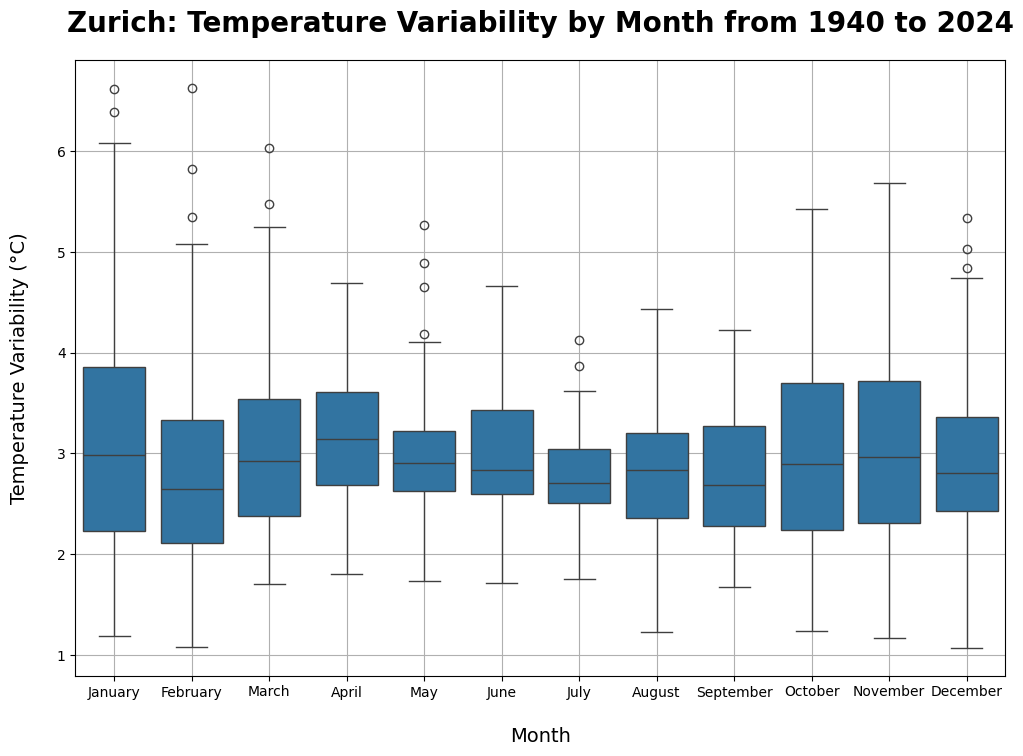

In [203]:
# Plotting monthly box plots of standard deviation
plt.figure(figsize=(12, 8))
sns.boxplot(x='Month', y='monthly_temp_sd', data=zurich_temp, order=calendar.month_name[1:])
plt.title('Zurich: Temperature Variability by Month from 1940 to 2024', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=14, labelpad=20)  
plt.ylabel('Temperature Variability (°C)', fontsize=14, labelpad=20)  
plt.grid(True)
plt.show()

Temperature variablity in extremes in colder months seems to be much higher than in warmer months. Median values are pretty stable.

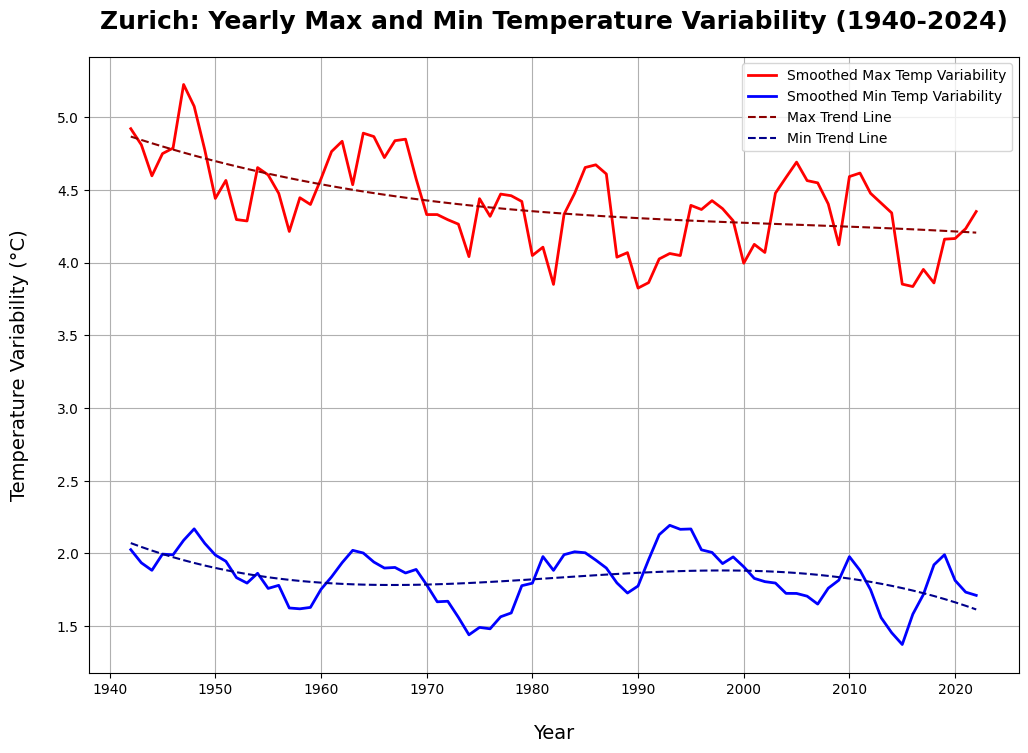

In [145]:
# Calculate the yearly maximum and minimum temperature variability
yearly_extremes = zurich_temp.groupby('Year')['monthly_temp_sd'].agg(['max', 'min']).reset_index()

# Apply a rolling mean to smooth the data (using a 5-year window)
yearly_extremes['max_smooth'] = yearly_extremes['max'].rolling(window=5, center=True).mean()
yearly_extremes['min_smooth'] = yearly_extremes['min'].rolling(window=5, center=True).mean()

# Drop rows with NaN values after smoothing
yearly_extremes = yearly_extremes.dropna(subset=['max_smooth', 'min_smooth'])

# Polynomial fitting for trend lines (3rd degree polynomial)
max_poly = np.polyfit(yearly_extremes['Year'], yearly_extremes['max_smooth'], 3)
min_poly = np.polyfit(yearly_extremes['Year'], yearly_extremes['min_smooth'], 3)

# Create polynomial functions
max_trend = np.poly1d(max_poly)
min_trend = np.poly1d(min_poly)

# Plotting the smoothed curves and trend lines
plt.figure(figsize=(12, 8))
plt.plot(yearly_extremes['Year'], yearly_extremes['max_smooth'], label='Smoothed Max Temp Variability', color='red', linewidth=2)
plt.plot(yearly_extremes['Year'], yearly_extremes['min_smooth'], label='Smoothed Min Temp Variability', color='blue', linewidth=2)

# Plotting the trend lines
plt.plot(yearly_extremes['Year'], max_trend(yearly_extremes['Year']), linestyle='--', color='darkred', label='Max Trend Line')
plt.plot(yearly_extremes['Year'], min_trend(yearly_extremes['Year']), linestyle='--', color='darkblue', label='Min Trend Line')

# Adding titles and labels
plt.title('Zurich: Yearly Max and Min Temperature Variability (1940-2024)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Temperature Variability (°C)', fontsize=14, labelpad=20)

# Adding a legend and grid
plt.legend(loc='upper right')
plt.grid(True)

# Display the plot
plt.show()

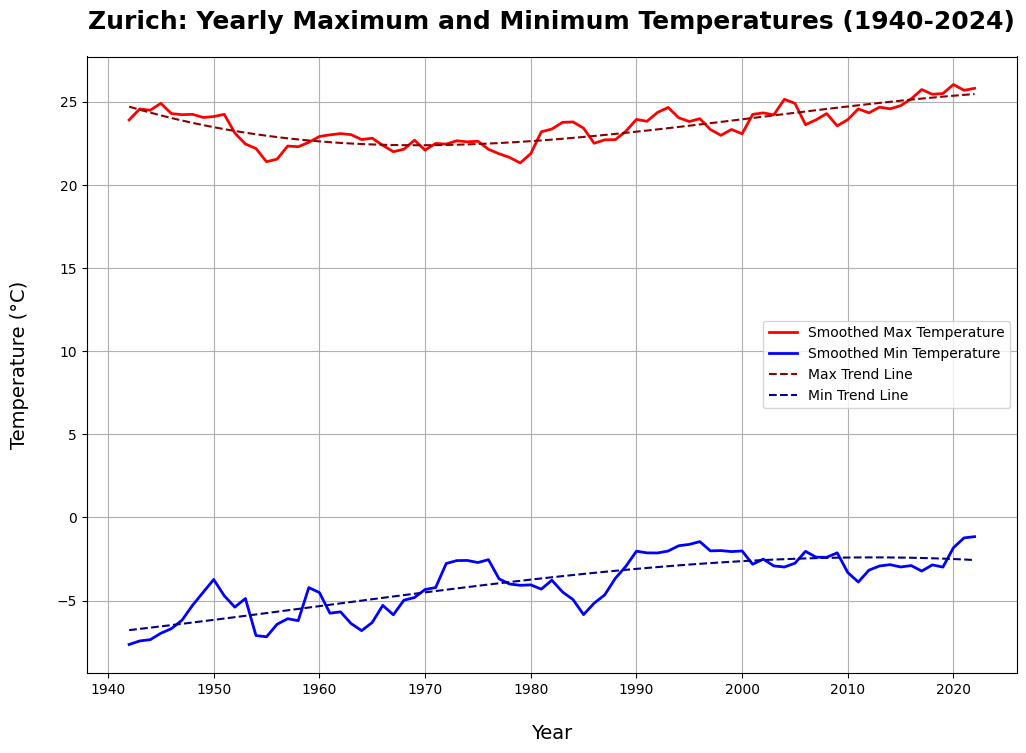

In [146]:
# Aggregate data to get yearly max and min temperatures
yearly_temps = zurich_temp.groupby('Year').agg({'monthly_max_temp': 'max', 'monthly_min_temp': 'min'}).reset_index()

# Apply a rolling mean to smooth the data (using a 5-year window)
yearly_temps['max_smooth'] = yearly_temps['monthly_max_temp'].rolling(window=5, center=True).mean()
yearly_temps['min_smooth'] = yearly_temps['monthly_min_temp'].rolling(window=5, center=True).mean()

# Drop NaN values after smoothing
yearly_temps = yearly_temps.dropna(subset=['max_smooth', 'min_smooth'])

# Polynomial fitting for trend lines (3rd degree polynomial)
max_poly = np.polyfit(yearly_temps['Year'], yearly_temps['max_smooth'], 3)
min_poly = np.polyfit(yearly_temps['Year'], yearly_temps['min_smooth'], 3)

# Create polynomial functions
max_trend = np.poly1d(max_poly)
min_trend = np.poly1d(min_poly)

# Plotting the smoothed curves and trend lines
plt.figure(figsize=(12, 8))

# Smoothed curves
plt.plot(yearly_temps['Year'], yearly_temps['max_smooth'], label='Smoothed Max Temperature', color='red', linewidth=2)
plt.plot(yearly_temps['Year'], yearly_temps['min_smooth'], label='Smoothed Min Temperature', color='blue', linewidth=2)

# Trend lines
plt.plot(yearly_temps['Year'], max_trend(yearly_temps['Year']), linestyle='--', color='darkred', label='Max Trend Line')
plt.plot(yearly_temps['Year'], min_trend(yearly_temps['Year']), linestyle='--', color='darkblue', label='Min Trend Line')

# Adding titles and labels
plt.title('Zurich: Yearly Maximum and Minimum Temperatures (1940-2024)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Temperature (°C)', fontsize=14, labelpad=20)

# Adding a legend and grid
plt.legend(loc='center right')
plt.grid(True)

# Display the plot
plt.show()

## Wind Speed Analysis

In [102]:
Weather.columns

Index(['weather_code', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean',
       'daylight_duration', 'sunshine_duration', 'precipitation_sum',
       'rain_sum', 'snowfall_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_gusts_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'City'],
      dtype='object')

In [204]:
Weather["gust_factor"] = Weather["wind_gusts_10m_max"] / Weather["wind_speed_10m_max"]
lta_windpseed_zurich = Weather["wind_speed_10m_max"].mean()

wind_aggregation = Weather.groupby(["City", Weather.index.year, Weather.index.month]).agg(
    mean_wind_speed=("wind_speed_10m_max", "mean"),
    sd_wind_speed=("wind_speed_10m_max", "std"),
    mean_wind_gust=("wind_gusts_10m_max", "mean"),
    sd_wind_gust=("wind_gusts_10m_max", "std"),
    mean_gust_factor=("gust_factor", "mean"),
    sd_gust_factor=("gust_factor", "std"),
)

wind_aggregation.index.set_names(["City", "Year", "Month"], inplace=True)
wind_aggregation = wind_aggregation.reset_index()
wind_aggregation["windiness_index"] = (wind_aggregation["mean_wind_speed"]/lta_windpseed_zurich)*100
wind_aggregation["Month"] = wind_aggregation["Month"].map(lambda x: calendar.month_name[int(x)])
wind_aggregation.head()

#Calculate long term average winspeed for yearly comparison (lta_windspeed)



,City,Year,Month,mean_wind_speed,sd_wind_speed,mean_wind_gust,sd_wind_gust,mean_gust_factor,sd_gust_factor,windiness_index
0,Seattle,1940,January,15.547169,3.463926,36.255483,8.658577,2.327152,0.134826,117.066221
1,Seattle,1940,February,14.462809,5.041536,34.411034,11.789859,2.386075,0.238302,108.901269
2,Seattle,1940,March,17.239597,5.257972,42.596128,11.547861,2.510207,0.257428,129.809778
3,Seattle,1940,April,19.318517,7.614460,47.735999,17.550367,2.507583,0.328172,145.463515
4,Seattle,1940,May,17.388715,5.642728,42.503225,13.210230,2.469944,0.284633,130.932594


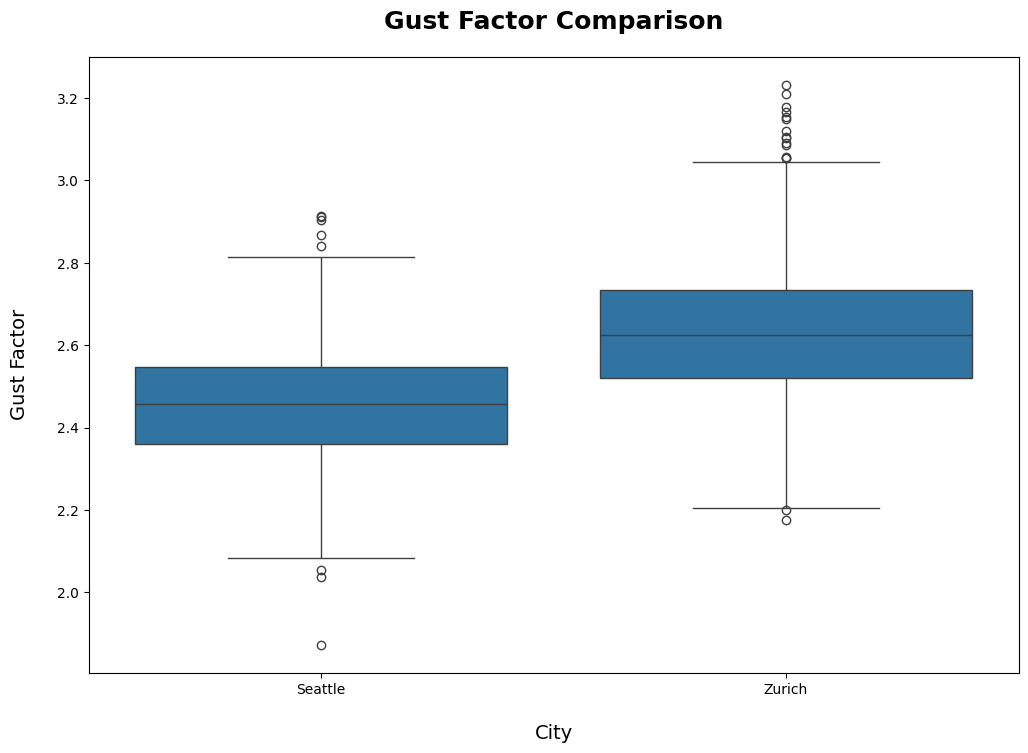

In [149]:
plt.figure(figsize=(12, 8))  # Set figure size
sns.boxplot(data=wind_aggregation, x="City", y="mean_gust_factor")
plt.title("Gust Factor Comparison", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("City", fontsize=14, labelpad=20)
plt.ylabel("Gust Factor", fontsize=14, labelpad=20)
plt.show()

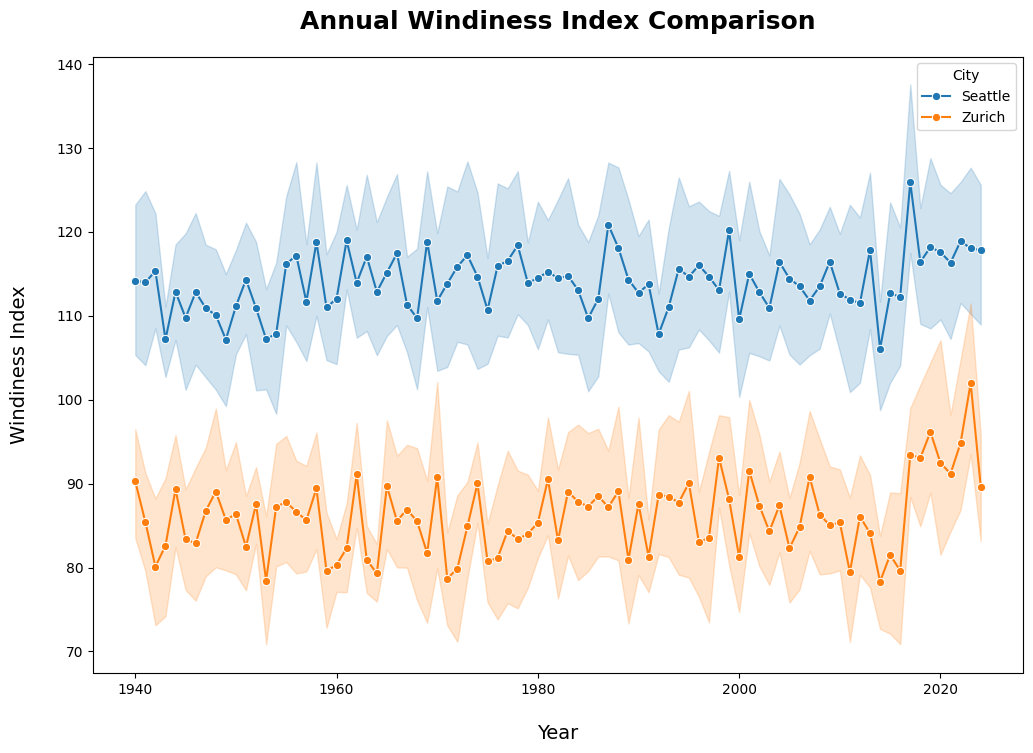

In [160]:
plt.figure(figsize=(12, 8)) 
sns.lineplot(data=wind_aggregation, x="Year", y="windiness_index", hue="City", marker="o")
plt.title("Annual Windiness Index Comparison", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, labelpad=20)
plt.ylabel("Windiness Index", fontsize=14, labelpad=20)
plt.show()

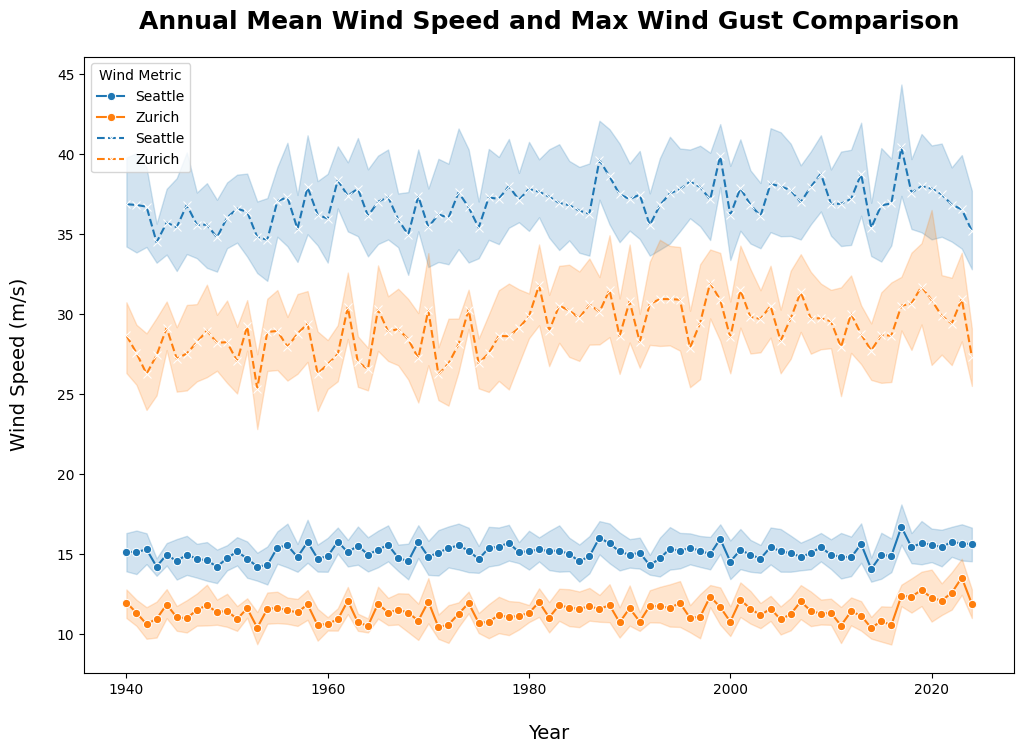

In [152]:
plt.figure(figsize=(12, 8))

# Plotting the mean wind speed
sns.lineplot(data=wind_aggregation, x="Year", y="mean_wind_speed", hue="City", marker="o")

# Plotting the maximum gust on the same plot
sns.lineplot(data=wind_aggregation, x="Year", y="mean_wind_gust", hue="City", marker="x", linestyle="--")

# Title and labels
plt.title("Annual Mean Wind Speed and Max Wind Gust Comparison", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, labelpad=20)
plt.ylabel("Wind Speed (m/s)", fontsize=14, labelpad=20)

# Display legend
plt.legend(title="Wind Metric", loc="upper left")

plt.show()

Global ‘Stilling’: Research indicates that from 1978 until 2010, there was a worldwide decrease in wind speeds. 

Text(0, 0.5, 'Gust Factor')

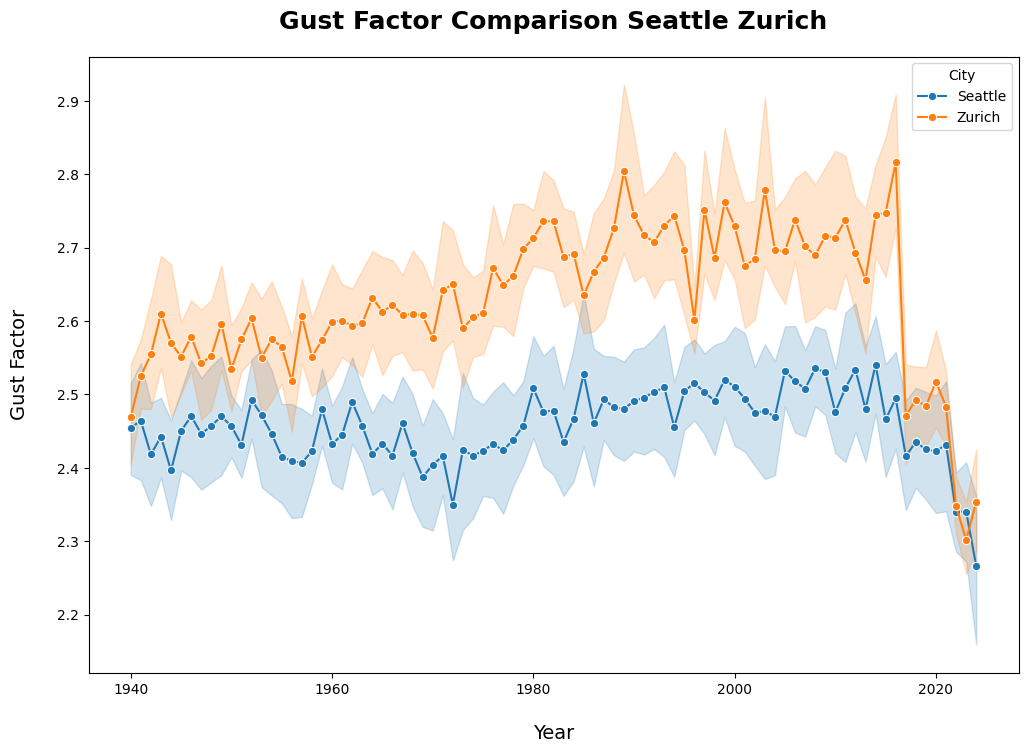

In [153]:
plt.figure(figsize=(12, 8))
sns.lineplot(data = wind_aggregation, x = "Year", y = "mean_gust_factor" , hue = "City", marker="o" )
plt.title("Gust Factor Comparison Seattle Zurich", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, labelpad=20)
plt.ylabel("Gust Factor", fontsize=14, labelpad=20)


Global ‘Stilling’: Research indicates that from 1978 until 2010, there was a worldwide decrease in wind speeds. La Niña Events. Calculate the Windiness Index:
Divide the annual mean wind speed by the long-term average wind speed, then multiply by 100 to express it as a percentage: ￼
Annual Mean windspeed/Dataset average ) * 100 = Compare windpseed in comparison to alltime average


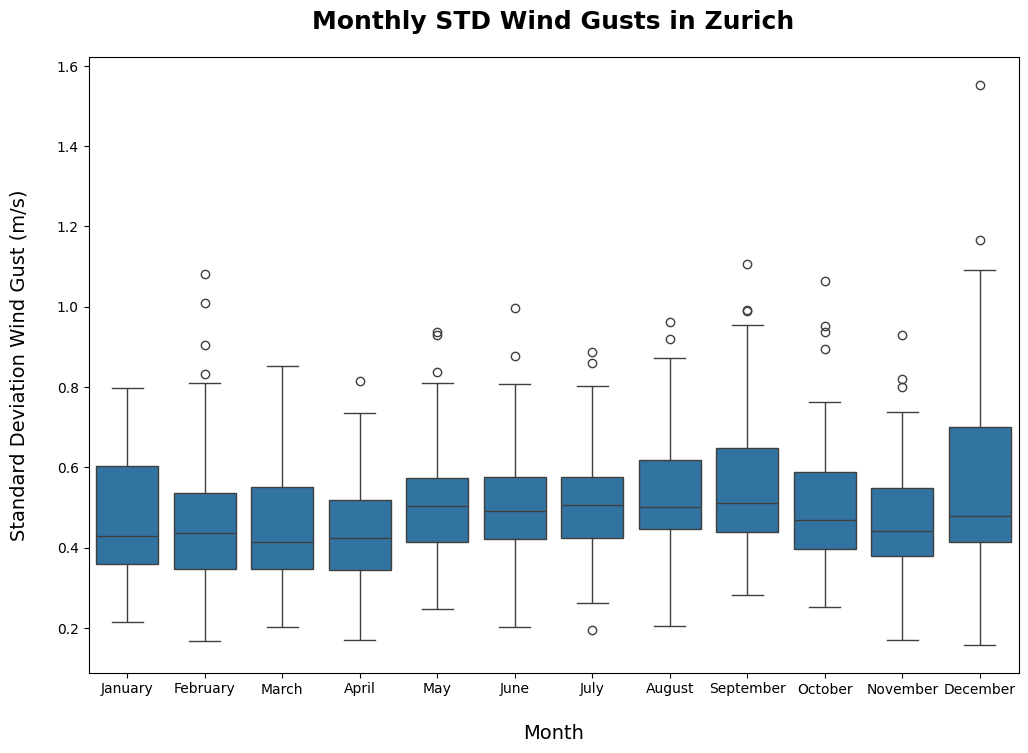

In [205]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=wind_aggregation[wind_aggregation["City"] == "Zurich"], x="Month", y="sd_gust_factor")
plt.title("Monthly STD Wind Gusts in Zurich", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Month", fontsize=14, labelpad=20)
plt.ylabel("Standard Deviation Wind Gust (m/s)", fontsize=14, labelpad=20)
plt.show()

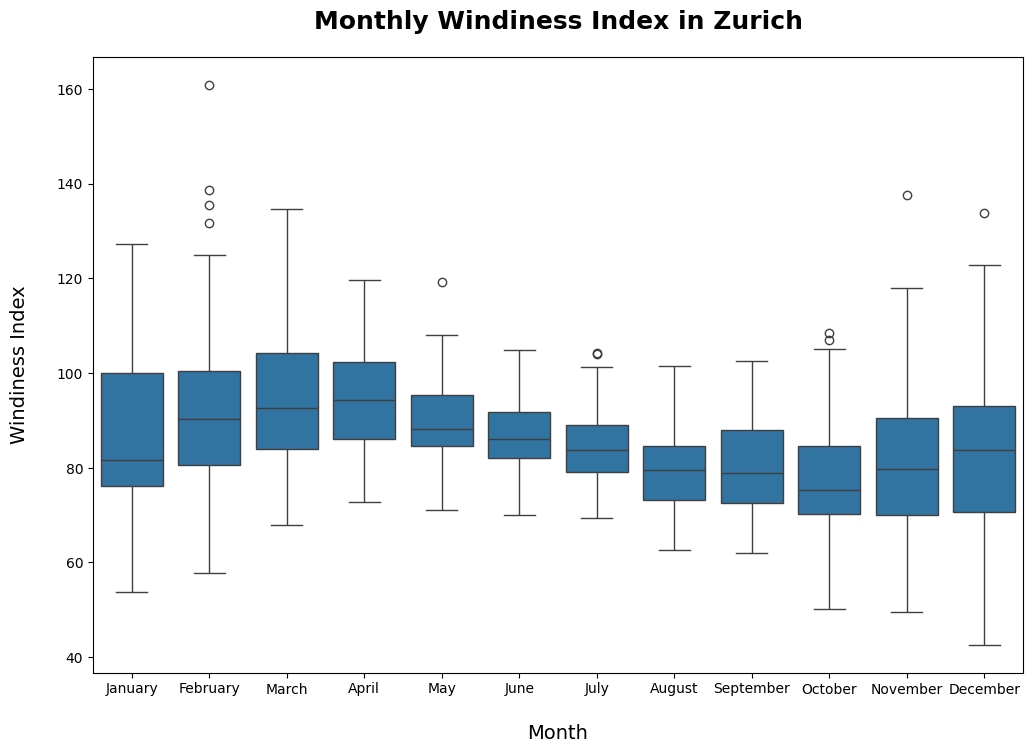

In [206]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=wind_aggregation[wind_aggregation["City"] == "Zurich"], x="Month", y="windiness_index")
plt.title("Monthly Windiness Index in Zurich", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Month", fontsize=14, labelpad=20)
plt.ylabel("Windiness Index", fontsize=14, labelpad=20)
plt.show()

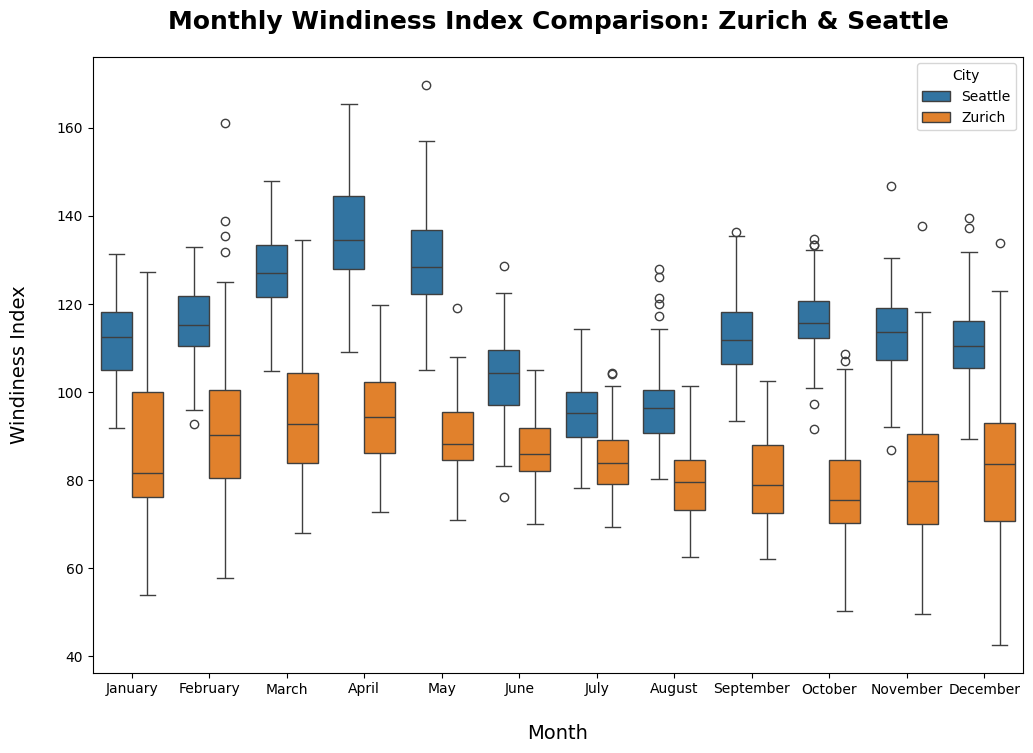

In [207]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=wind_aggregation, x="Month", y="windiness_index", hue="City")
plt.title("Monthly Windiness Index Comparison: Zurich & Seattle", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Month", fontsize=14, labelpad=20)
plt.ylabel("Windiness Index", fontsize=14, labelpad=20)
plt.show()

In [215]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=wind_aggregation, )

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

## Sunshine and Cloudiness Analysis


In [209]:
# Calculate sunlight percentage
Weather["sunlight_percentage"] = (Weather["sunshine_duration"] / Weather["daylight_duration"]) * 100

# Aggregate for sunlight percentage
sunshine_aggregate = Weather.groupby(["City", Weather.index.year, Weather.index.month]).agg(
    mean_sunlight_percentage=("sunlight_percentage", "mean"),
    sd_sunlight_percentage=("sunlight_percentage", "std"),
)
sunshine_aggregate.index.set_names(["City", "Year", "Month"], inplace=True)
sunshine_aggregate = sunshine_aggregate.reset_index()
sunshine_aggregate["Month"] = sunshine_aggregate["Month"].map(lambda x: calendar.month_name[int(x)])
sunshine_aggregate.head()

,City,Year,Month,mean_sunlight_percentage,sd_sunlight_percentage
0,Seattle,1940,January,84.724093,4.495105
1,Seattle,1940,February,84.989410,10.179459
2,Seattle,1940,March,84.219067,11.716866
3,Seattle,1940,April,68.308834,22.393532
4,Seattle,1940,May,63.931861,24.393086


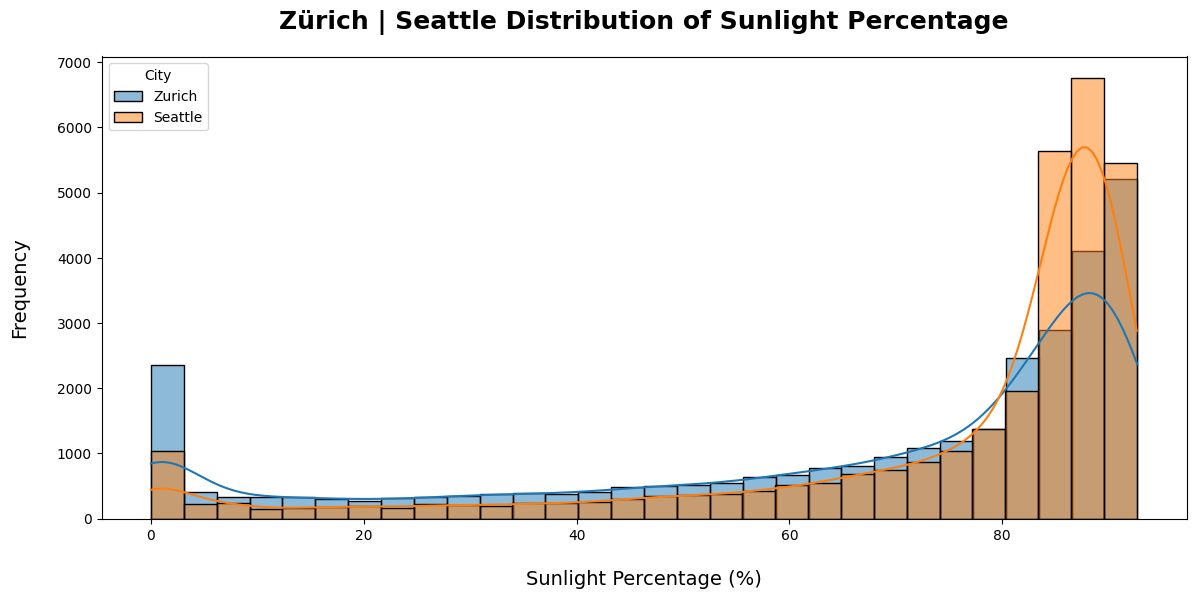

In [214]:
#Check the distribution before fitting a model
plt.figure(figsize=(14, 6))

# Plot for Zurich with a label
sns.histplot(Weather[Weather["City"] == "Zurich"]["sunlight_percentage"], bins=30, kde=True, label="Zurich")

# Plot for Seattle with a label
sns.histplot(Weather[Weather["City"] == "Seattle"]["sunlight_percentage"], bins=30, kde=True, label="Seattle")

# Title and labels
plt.title("Zürich | Seattle Distribution of Sunlight Percentage", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Sunlight Percentage (%)", fontsize=14, labelpad=20)
plt.ylabel("Frequency", fontsize=14, labelpad=20)

# Add a legend to differentiate between cities
plt.legend(title="City")
plt.show()



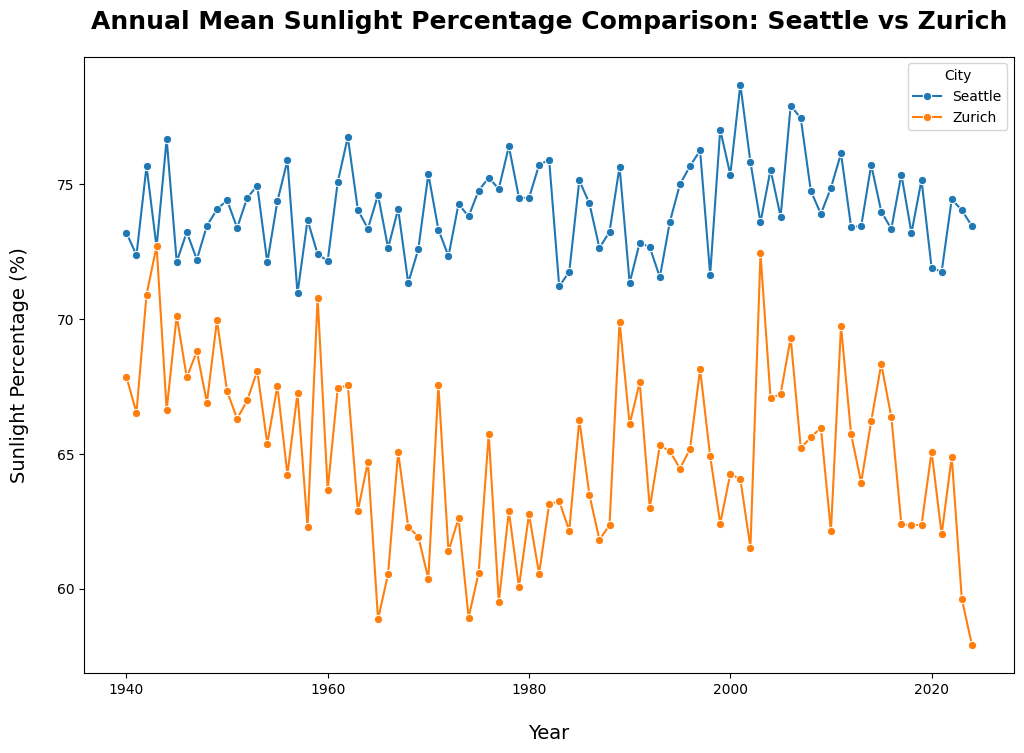

In [199]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=sunshine_aggregate, x="Year", y="mean_sunlight_percentage", hue="City", marker="o",  errorbar=None)
plt.title("Annual Mean Sunlight Percentage Comparison: Seattle vs Zurich", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, labelpad=20)
plt.ylabel("Sunlight Percentage (%)", fontsize=14, labelpad=20)
plt.show()

Fitted Parameters: A=-2.939, B=0.113, C=-26.875, D=64.504


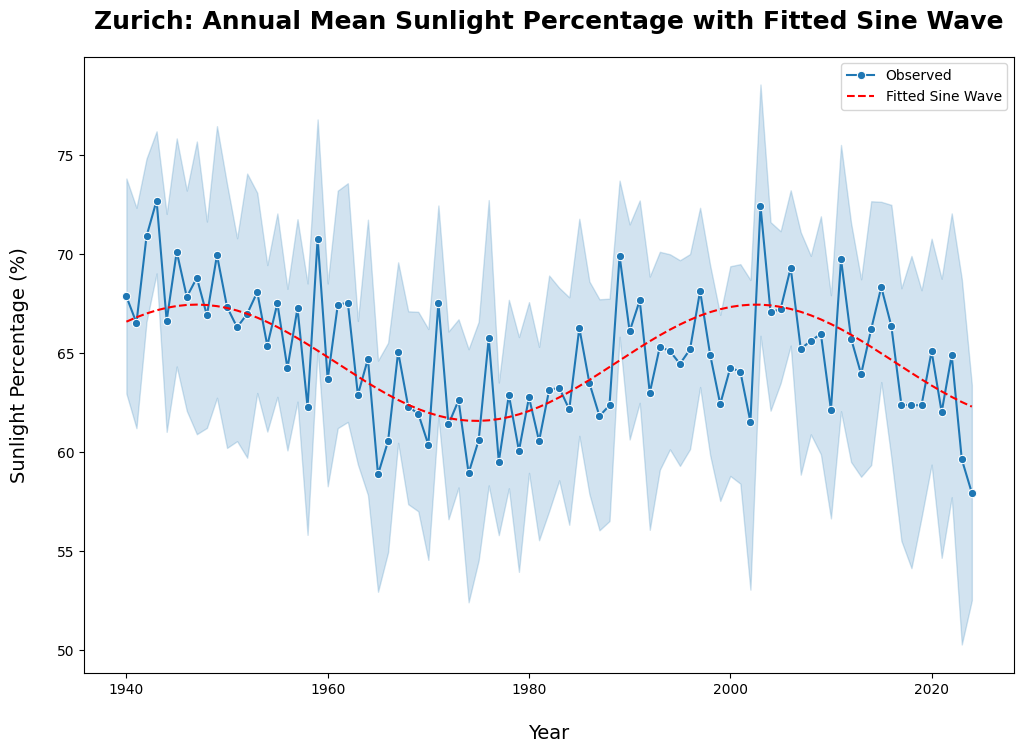

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

# Define the sine wave function
def sine_function(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

# Filter Zurich data from the aggregated dataframe
zurich_sunlight = sunshine_aggregate[sunshine_aggregate["City"] == "Zurich"]

# Initial guesses for amplitude (A), frequency (B), phase shift (C), and vertical shift (D)
initial_guess = [10, 0.1, 0, 70]

# Fit the sine function to the data
params, _ = curve_fit(sine_function, zurich_sunlight["Year"], zurich_sunlight["mean_sunlight_percentage"], p0=initial_guess)

# Extract the fitted parameters
A, B, C, D = params
print(f"Fitted Parameters: A={A:.3f}, B={B:.3f}, C={C:.3f}, D={D:.3f}")

# Generate fitted sine wave values
fitted_sine = sine_function(zurich_sunlight["Year"], A, B, C, D)

# Plot the original data and the fitted sine wave
plt.figure(figsize=(12, 8))
sns.lineplot(data=zurich_sunlight, x="Year", y="mean_sunlight_percentage", label="Observed", marker="o")
plt.plot(zurich_sunlight["Year"], fitted_sine, color="red", linestyle="--", label="Fitted Sine Wave")

# Add titles and labels
plt.title("Zurich: Annual Mean Sunlight Percentage with Fitted Sine Wave", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, labelpad=20)
plt.ylabel("Sunlight Percentage (%)", fontsize=14, labelpad=20)
plt.legend()

# Show the plot
plt.show()